# data structure design

We are using tusimple dataset as raw dataset for training. Overview: [link](https://github.com/TuSimple/tusimple-benchmark/tree/master/doc/lane_detection)

Tusimple json format is:

In [ ]:
{
  'raw_file': str. 20th frame file path in a clip.
  'lanes': list. A list of lanes. For each list of one lane, the elements are width values on image.
  'h_samples': list. A list of height values corresponding to the 'lanes', which means len(h_samples) == len(lanes[i])
}

for example

In [ ]:
{
  "lanes": [
        [-2, -2, -2, -2, 632, 625, 617, 609, 601, 594, 586, 578, 570, 563, 555, 547, 539, 532, 524, 516, 508, 501, 493, 485, 477, 469, 462, 454, 446, 438, 431, 423, 415, 407, 400, 392, 384, 376, 369, 361, 353, 345, 338, 330, 322, 314, 307, 299],
        [-2, -2, -2, -2, 719, 734, 748, 762, 777, 791, 805, 820, 834, 848, 863, 877, 891, 906, 920, 934, 949, 963, 978, 992, 1006, 1021, 1035, 1049, 1064, 1078, 1092, 1107, 1121, 1135, 1150, 1164, 1178, 1193, 1207, 1221, 1236, 1250, 1265, -2, -2, -2, -2, -2],
        [-2, -2, -2, -2, -2, 532, 503, 474, 445, 416, 387, 358, 329, 300, 271, 241, 212, 183, 154, 125, 96, 67, 38, 9, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2],
        [-2, -2, -2, 781, 822, 862, 903, 944, 984, 1025, 1066, 1107, 1147, 1188, 1229, 1269, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]
       ],
  "h_samples": [240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710],
  "raw_file": "path_to_clip"
}

We should process the dataset as sharegpt style sft format like that:

In [ ]:
{
    "images": [
      "/media/zzcc/file/aigc/llm/datasets/TUSimple/train_set/clips/0313-1/6040/20.jpg"
    ],
    "messages": [
      {
        "role": "user",
        "content": "<image>\nDetect all lane lines. Output each lane as a list of (x, y) coordinates in JSON format."
      },
      {
        "role": "assistant",
        "content": "{\"lanes\": [[{\"x\": 632, \"y\": 280}, {\"x\": 601, \"y\": 320}, {\"x\": 563, \"y\": 370}, {\"x\": 524, \"y\": 420}, {\"x\": 485, \"y\": 470}, {\"x\": 454, \"y\": 510}, {\"x\": 415, \"y\": 560}, {\"x\": 376, \"y\": 610}, {\"x\": 338, \"y\": 660}, {\"x\": 299, \"y\": 710}], \
                                 [{\"x\": 719, \"y\": 280}, {\"x\": 777, \"y\": 320}, {\"x\": 834, \"y\": 360}, {\"x\": 891, \"y\": 400}, {\"x\": 949, \"y\": 440}, {\"x\": 1021, \"y\": 490}, {\"x\": 1078, \"y\": 530}, {\"x\": 1135, \"y\": 570}, {\"x\": 1193, \"y\": 610}, {\"x\": 1265, \"y\": 660}], \
                                 [{\"x\": 532, \"y\": 290}, {\"x\": 474, \"y\": 310}, {\"x\": 416, \"y\": 330}, {\"x\": 358, \"y\": 350}, {\"x\": 300, \"y\": 370}, {\"x\": 241, \"y\": 390}, {\"x\": 183, \"y\": 410}, {\"x\": 125, \"y\": 430}, {\"x\": 67, \"y\": 450}, {\"x\": 9, \"y\": 470}], \
                                 [{\"x\": 781, \"y\": 270}, {\"x\": 822, \"y\": 280}, {\"x\": 862, \"y\": 290}, {\"x\": 944, \"y\": 310}, {\"x\": 984, \"y\": 320}, {\"x\": 1025, \"y\": 330}, {\"x\": 1107, \"y\": 350}, {\"x\": 1147, \"y\": 360}, {\"x\": 1188, \"y\": 370}, {\"x\": 1269, \"y\": 390}]\
                                ]\
                    }"
      }
    ]
  }

# Generate dataset for llama factory

In [ ]:
DATASET_NAME = "tusimple_llamafactory_tiny"
OUTPUT_JSON = f"./{DATASET_NAME}.json"
TUSIMPLE_ROOT = "/media/zzcc/file/aigc/llm/datasets/TUSimple/train_set/"  # 替换为你的路径

In [ ]:
import json
import os
from pathlib import Path
import numpy as np

points = 10  # 每条车道线采样点数

def convert_tusimple_to_llamafactory_tiny(
    tusimple_root: str,
    output_json_path: str,
    split: str = "train"
):
    label_files = []
    if split == "train":
        label_files = [
            "label_data_0313.json",
            "label_data_0601.json",
            "label_data_0531.json"
        ]
    else:
        label_files = ["test_tasks_0627.json"]

    dataset = []

    for label_file in label_files:
        with open(os.path.join(tusimple_root, label_file), 'r') as f:
            for line in f:
                data = json.loads(line.strip())
                img_path = os.path.join(tusimple_root, data["raw_file"])
                if not os.path.exists(img_path):
                    continue

                h_samples = data["h_samples"]
                lanes = data["lanes"]

                # 构建车道线坐标列表
                lane_coords = []
                for lane in lanes:
                    coords = []
                    for x, y in zip(lane, h_samples):
                        if x >= 0:  # 有效点
                            coords.append({"x": int(x), "y": int(y)})
                    
                    # 只处理至少有5个点的车道
                    if len(coords) < points:
                        continue  # 或者你可以选择跳过，或 pad，这里跳过

                    # 等距采样5个点：首、中3、尾，间隔相同
                    indices = np.linspace(0, len(coords) - 1, num=points, dtype=int)
                    sampled_coords = [coords[i] for i in indices]
                    lane_coords.append(sampled_coords)

                # 只保留至少有一条车道的数据
                if not lane_coords:
                    continue

                # 构造 Llama Factory 格式
                output_dict = {"lanes": lane_coords}
                output_str = json.dumps(output_dict) 

                sample = {
                    "images": [img_path],
                    "messages": [
                        {
                            "role": "user",
                            "content": "<image>\nDetect all lane lines. Output each lane as a list of (x, y) coordinates in JSON format."
                        },
                        {
                            "role": "assistant",
                            "content": output_str
                        }
                    ]
                }
                dataset.append(sample)

    # 保存到本地 JSON
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(dataset, f, indent=2, ensure_ascii=False)

    print(f"✅ Saved {len(dataset)} samples to {output_json_path}")


if __name__ == "__main__":
    convert_tusimple_to_llamafactory_tiny(TUSIMPLE_ROOT, OUTPUT_JSON, split="train")

✅ Saved 3626 samples to ./tusimple_llamafactory_tiny.json


testing: preview one original image and drive lane.

In [13]:
#%pip install opencv-python

def dataset_preview(index=0):
    with open(OUTPUT_JSON, 'r', encoding='utf-8') as f:
        data = json.load(f)
    first_obj = data[index]
    #print(json.dumps(first_obj, indent=2, ensure_ascii=False))

    # read image 
    import cv2
    image = cv2.imread(first_obj['images'][0])

    extracted_lanes = json.loads(first_obj['messages'][1]['content'])['lanes']
    #print(extracted_lanes)
    for lane in extracted_lanes:
        for point in lane:
            cv2.circle(image, (point['x'], point['y']), 3, (0, 0, 255), -1)
            # 在点旁边添加坐标文本
            x = point['x']
            y = point['y']
            text = f'({x},{y})'
            cv2.putText(image, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)  # 绿色文字

    # cv2.imshow('image', image)
    # cv2.waitKey(0)

    import matplotlib.pyplot as plt
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(1920/100 , 1920/100 * image.shape[0]/image.shape[1]))
    plt.imshow(rgb_image)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

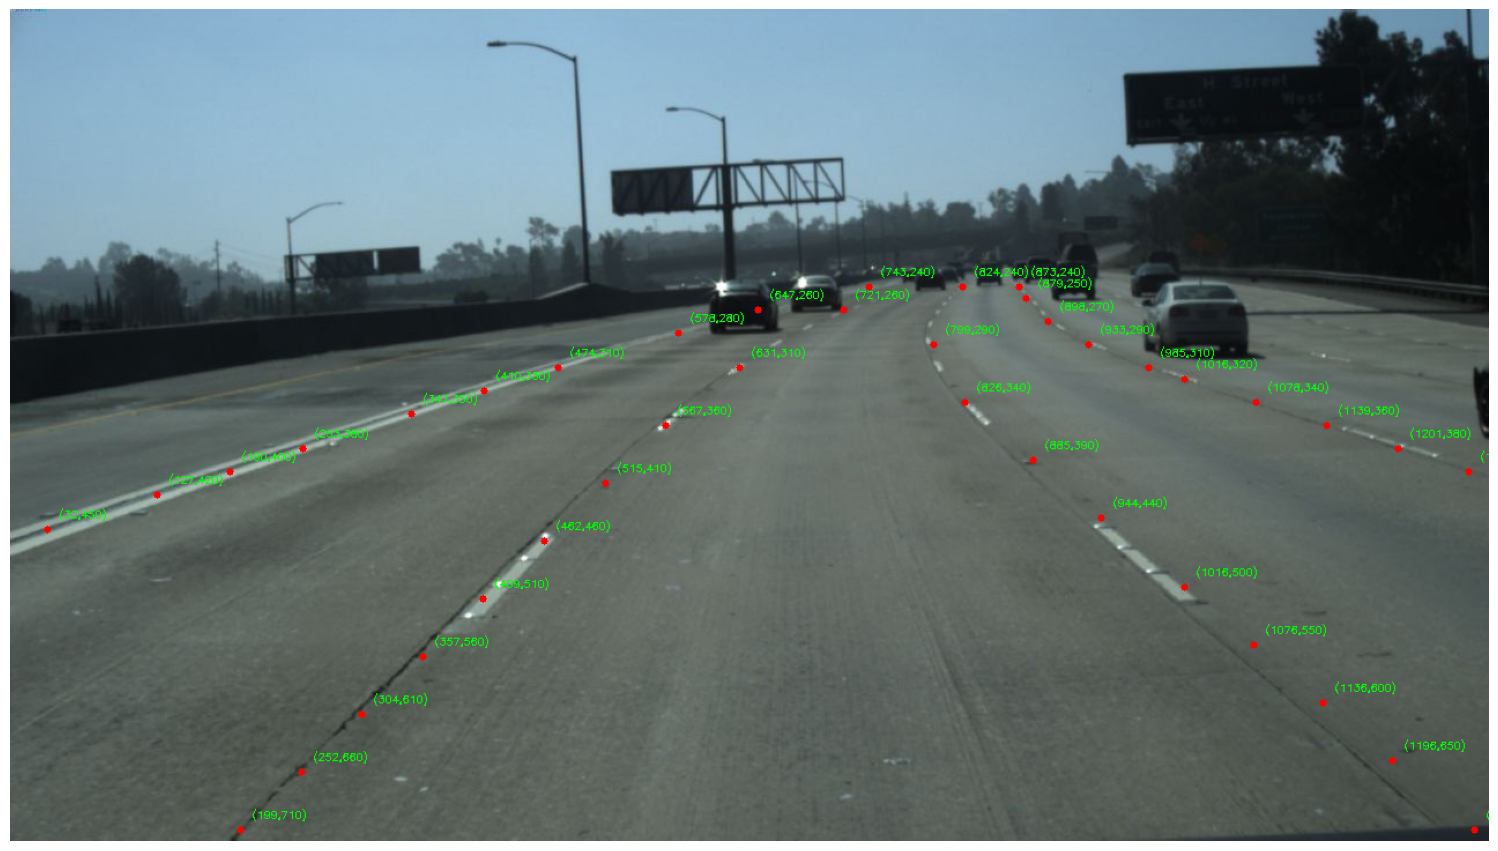

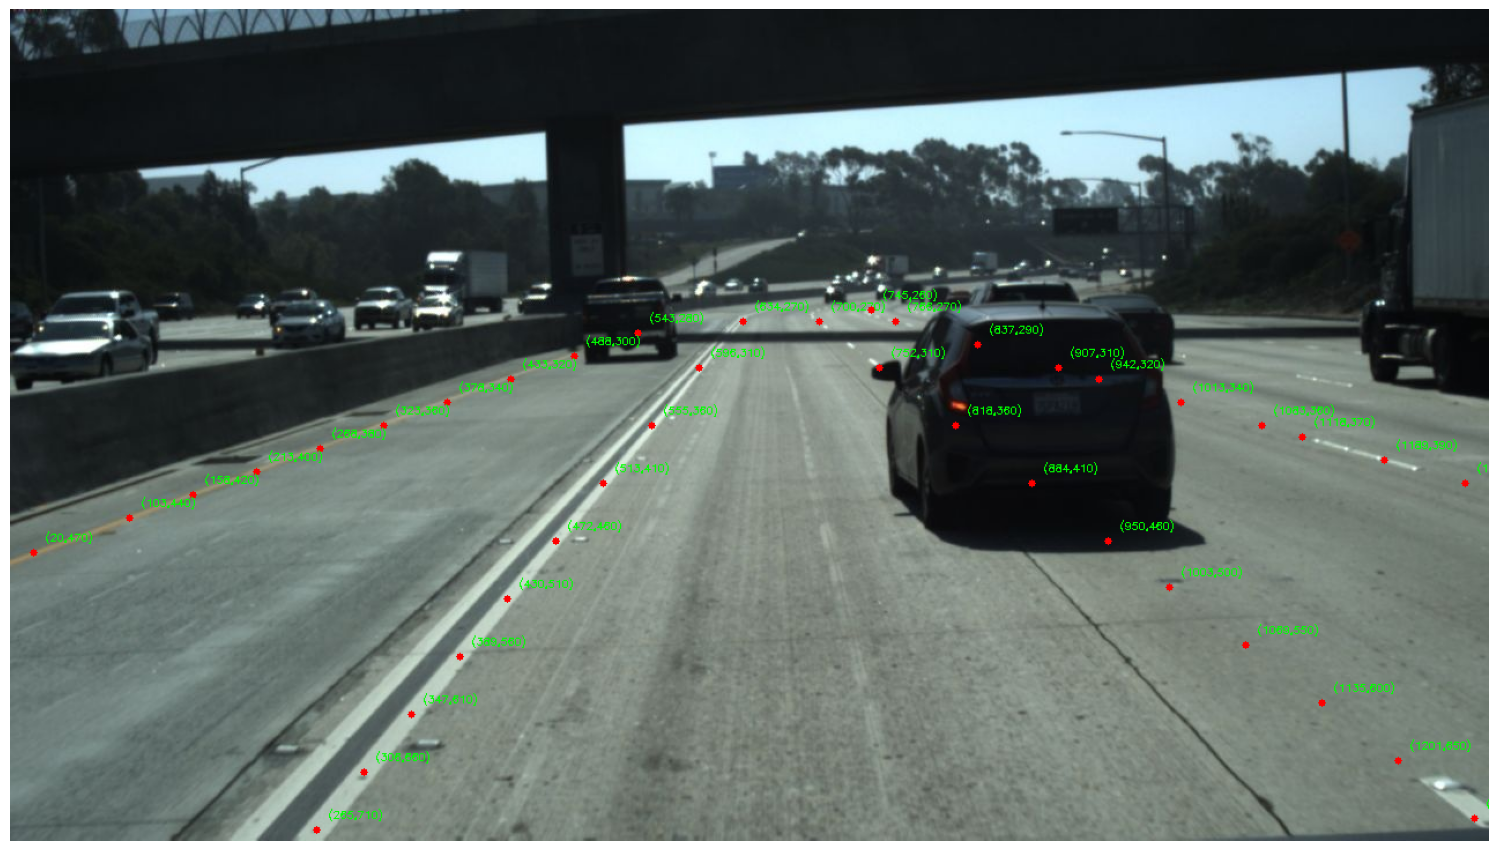

In [ ]:
dataset_preview(101)
dataset_preview(201)

generate a dataset_info.json file

In [9]:
data_path = 'dataset_info.json'

data = {}
data[DATASET_NAME] = {
    "file_name": f"{DATASET_NAME}.json",
    "formatting": "sharegpt",
    "columns": {
    "messages": "messages",
    "images": "images"
    },
    "tags": {
    "role_tag": "role",
    "content_tag": "content",
    "user_tag": "user",
    "assistant_tag": "assistant"
    }
}

with open(data_path, 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=2, ensure_ascii=False)


# Training

activate env

In [ ]:
!conda activate llm_fac


## webui training

In [ ]:
!llamafactory-cli webui 

# Training result: https://swanlab.cn/@zhouluo/llamafactory/runs/tepoli2n604jhwe7510eq/chart

## terminal training using 2025-10-09.yaml

In [ ]:
!llamafactory-cli train 2025-10-09-00-24-12.yaml

# Validation

In [ ]:
import json
import cv2

def evaluate(pic_name):
    image = cv2.imread(pic_name)

    with open('test_json.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
        lanes = data['lanes']
        for lane in lanes:
            print(lane)
            for point in lane:
                cv2.circle(image, (point['x'], point['y']), 3, (0, 255, 255), -1)
                # 在点旁边添加坐标文本
                x = point['x']
                y = point['y']
                text = f'({x},{y})'
                cv2.putText(image, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)  # 绿色文字

    import matplotlib.pyplot as plt
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(1920/100 , 1920/100 * image.shape[0]/image.shape[1]))
    plt.imshow(rgb_image)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

[{'x': 562, 'y': 240}, {'x': 547, 'y': 250}, {'x': 532, 'y': 260}, {'x': 518, 'y': 270}, {'x': 503, 'y': 280}, {'x': 489, 'y': 290}, {'x': 474, 'y': 300}, {'x': 460, 'y': 310}, {'x': 445, 'y': 320}, {'x': 431, 'y': 330}, {'x': 416, 'y': 340}, {'x': 402, 'y': 350}, {'x': 387, 'y': 360}, {'x': 373, 'y': 370}, {'x': 358, 'y': 380}, {'x': 344, 'y': 390}, {'x': 329, 'y': 400}, {'x': 315, 'y': 410}, {'x': 300, 'y': 420}, {'x': 286, 'y': 430}, {'x': 271, 'y': 440}, {'x': 257, 'y': 450}, {'x': 242, 'y': 460}, {'x': 228, 'y': 470}, {'x': 213, 'y': 480}, {'x': 199, 'y': 490}, {'x': 184, 'y': 500}, {'x': 170, 'y': 510}, {'x': 155, 'y': 520}, {'x': 141, 'y': 530}, {'x': 126, 'y': 540}, {'x': 112, 'y': 550}, {'x': 97, 'y': 560}, {'x': 83, 'y': 570}, {'x': 68, 'y': 580}, {'x': 54, 'y': 590}, {'x': 39, 'y': 600}, {'x': 25, 'y': 610}]
[{'x': 622, 'y': 240}, {'x': 629, 'y': 250}, {'x': 635, 'y': 260}, {'x': 641, 'y': 270}, {'x': 647, 'y': 280}, {'x': 653, 'y': 290}, {'x': 659, 'y': 300}, {'x': 665, 'y'

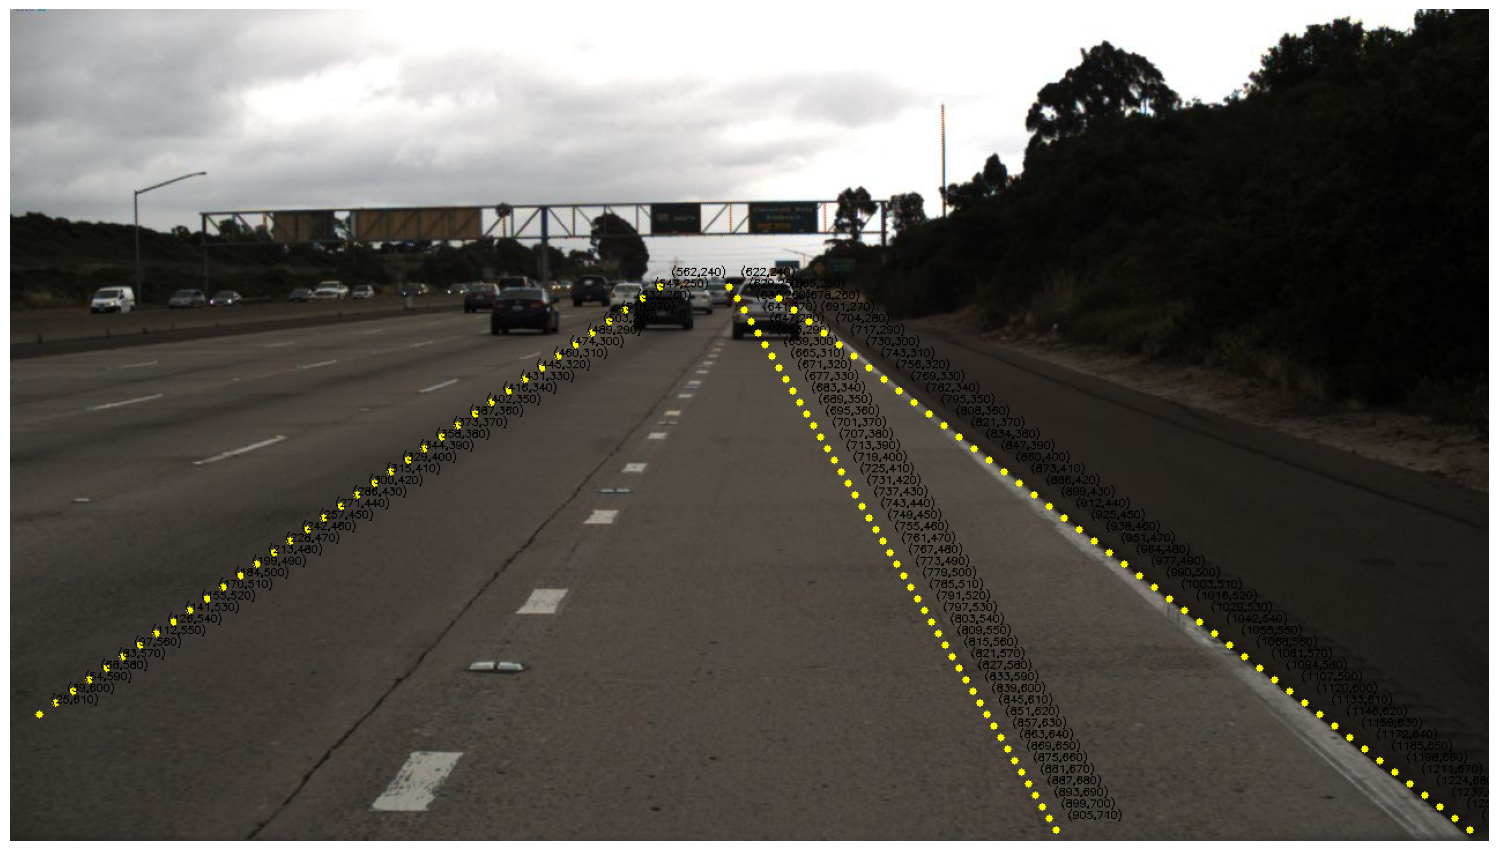

In [ ]:
evaluate('eval_1.jpg')
evaluate('eval_1.jpg')

# Chat

Use webUI for chat and picture comparation.
## DOING

In [ ]:
!cd $LLaMA_Factory_DIR

API_PORT=8000 CUDA_VISIBLE_DEVICES=0 llamafactory-cli api examples/inference/llama3_lora_sft.yaml

## infer a result and render it directly.

In [ ]:
# %pip install openai
DEFAULT_SFT_CKPT_PATH = '/media/zzcc/file/aigc/llm/models/Qwen/Qwen25-VL-3B-Instruct-finetune-full'

import base64
import os
from openai import OpenAI

image_path = "10.jpg"  # ←←← change to your image path!!!!
infer_image = cv2.imread(image_path)

# 将图片编码为 base64（适用于 JPEG/PNG）
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 确保文件存在
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image file not found: {image_path}")

base64_image = encode_image(image_path)

# 构造多模态消息
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Detect all lane lines. Output each lane as a list of (x, y) coordinates in JSON format."},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{base64_image}"
                }
            }
        ]
    }
]

# 调用模型
client = OpenAI(api_key="0",base_url="http://0.0.0.0:8000/v1")
result = client.chat.completions.create(
    model=DEFAULT_SFT_CKPT_PATH,
    messages=messages,
    max_tokens=20480  # 可选：防止生成过长
)

# 输出结果
# print(result.choices[0].message.content)
result_path = f'infer_result_{image_path}.json'
with open(result_path, 'w', encoding='utf-8') as f:
    f.write(result.choices[0].message.content)
    print("✅ Inference result saved to test_json.json")

data = json.loads(result.choices[0].message.content)
lanes = data['lanes']
for lane in lanes:
    print(lane)
    for point in lane:
        cv2.circle(infer_image, (point['x'], point['y']), 3, (0, 255, 255), -1)
        # 在点旁边添加坐标文本
        x = point['x']
        y = point['y']
        text = f'({x},{y})'
        cv2.putText(infer_image, text, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)  # 绿色文字

import matplotlib.pyplot as plt
rgb_image = cv2.cvtColor(infer_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(1920/100 , 1920/100 * infer_image.shape[0]/infer_image.shape[1]))
plt.imshow(rgb_image)
plt.axis('off')  # 不显示坐标轴
plt.show()